Welcome to the laboratory computers for the course "Neural signals and signal processing". The aim of the laboratories is to provide insights on how to analyze other kinds of imaging data: here in particular we will look at functional Near Infrared Spectroscopy (fNRIS) and diffusion-weighted MRI to generate tractography and a structural connectome.

In [2]:
%matplotlib inline

import os.path as op
import mne
import mne_nirs
import matplotlib.pyplot as plt
from mne.preprocessing.nirs import temporal_derivative_distribution_repair

<div class="alert alert-warning">
    <p><b>Please remember to run this notebook always with the command: "fsleyes --notebookFile lab_3_fNIRs_tracto.ipynb"! </b></p>
</div>

<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Neural Signals and Signal Processing (NX-421)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Part 1: Get acquainted with fNIRS data preprocessing </font></h1>


In contrast to functional magnetic resonance imaging (fMRI), functional Near-Infrared Spectroscopy (fNIRS) distinguishes itself with portability and adaptability, making it especially suitable for research involving intricate populations like infants, tasks characterized by motion, and real-world settings.

Nevertheless, it is important to acknowledge that collecting fNIRS data requires rigorous preprocessing. This requirement arises from fNIRS's susceptibility to 1) superficial physiological interferences, such as those stemming from scalp blood flow and 2) motion artifacts, especially those resulting from sensor displacement.

# 1. Visualization</font></h1>

Effective data preprocessing begins with data visualization to discern the desired and undesired variability (keep in mind the 1-10-100 dollar rule). 

## Data set

#### Description

We will work on a set of hemodynamic data measured on one subject during a finger tapping paradigm with three conditions: 1) Tapping the left thumb to fingers, 2) Tapping the right thumb to fingers and 3) A control when nothing happens. Each tapping lasts 5 seconds and there are 30 trials in each condition.The recording was performed using fNIRS sensors located over motor areas of the cortex. 

Data were provided by Luke, R., & McAlpine, D. (2021). fNIRS Finger Tapping Data in BIDS Format (Version v0.0.1) (https://doi.org/10.5281/zenodo.5529797),

#### Loading

Load the dataset by running the next cell.

In [3]:
#Download dataset
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
#Get the path for the dataset folder 
fnirs_data_folder=op.join(fnirs_data_folder, 'Participant-1')
#Load the dataset 
raw_intensity = mne.io.read_raw_nirx(fnirs_data_folder, verbose=True, preload=True)

Loading C:\Users\RDZaharSe\mne_data\MNE-fNIRS-motor-data\Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


#### Recording setting

Display and read information on the recording setting such as the number of channels, the file duration and the sampling frequency by runing the next cell. 

In [4]:
#Display recording setting
raw_intensity

<RawNIRX | Participant-1, 56 x 23239 (2974.5 s), ~10.0 MB, data loaded>

<span style="color:blue; text-decoration:underline;">Multiple Choice Question</span>

*Among the choices below, what is the shape of the measured dataset (number of fNIRS channels, timepoints) ?*
   1. (56, 23235)
   2. (17, 98888)
   3. (56, 78889) 
   4. (17, 23235)
   
   <p style="color:green"> Number of fNIRS channels = 56 ; Numbers of timepoints = sampling frequency x duration = 7.81Hz x (2975s)</p>


The placement of fNIRS sensors holds significance for achieving **a good spatial resolution** and an **accurate sensor placement**.

Let's take a look at the locations of sensors. Before that, you need to install two additional packages using the following terminal commands:

'pip install pyvistaqt'


'pip install ipywidgets'

In [5]:
subjects_dir = mne.datasets.sample.data_path() / "subjects"

brain = mne.viz.Brain(
    "fsaverage", subjects_dir=subjects_dir, background="w", cortex="0.5"
)
brain.add_sensors(
    raw_intensity.info,
    trans="fsaverage",
    fnirs=["channels", "pairs", "sources", "detectors"],
)
brain.show_view(azimuth=20, elevation=60, distance=400)

Using pyvistaqt 3d backend.

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

Channel types::	fnirs_cw_amplitude: 56


 
   <p style="color:green"> See below the expected 3D visualization of the fNIRS sensors placed over the head: </p>


<img src="3Dmap.png">

In the 3D visualization, we represent source-detector pairs as lines. Sources are shown as red dots and detectors as black dots. The midpoint of these pairs, which we call channels, is depicted as orange dots.

<span style="color:blue; text-decoration:underline;">Multiple Choice Question</span>

*What is the cortical region covered by this measurement ?*
1. Motor cortex
2. Visual cortex

   <p style="color:green"> In this finger tapping task, sensors are placed over the motor cortex. This region is located in the dorsal portion of the frontal lobe. </p>


#### Experimental design

Let's now have a look at the experimental design used.

The experimental designs most commonly employed by auditory fNIRS researchers are block- and event-related designs. In an event related design, each task is presented individually for a short amount of time e.g., 3 seconds. In this way, tasks can be more  randomized,  rather  than  being  blocked  together  by  condition. Conversely, in a block-related design, blocks of tasks, each lasting at least 10 seconds, recur before intervals of rest. 

The choice of the experimental design depends on a range of factors, including the statistical power, the duration of the experiment, and whether the design provides the flexibility to study the effect of interest. While the block design might lead to higher detection power, it can also induce learning and boredom effects which may bias the results. On the other hand, event-related designs reduce the effects of learning, boredom while exhibiting loss in detection power. 

<span style="color:blue; text-decoration:underline;">Open question</span>

*What are the analytical challenges associated with employing a block-related experimental design featuring continuous stimulation and brief rest blocks?*

   <p style="color:green"> In a block-related experimental design with continuous stimulation and brief rest blocks, we can end-up having a non-linear summation of the hemodynamic responses to stimuli. This non-linearity can cause a mismatch between the predicted  summation of responses obtained with linear approaches (e.g., averaging or general linear modelling) and the actual observed data. </p>







Run the next cell to display the sequence of events used in this experiment.

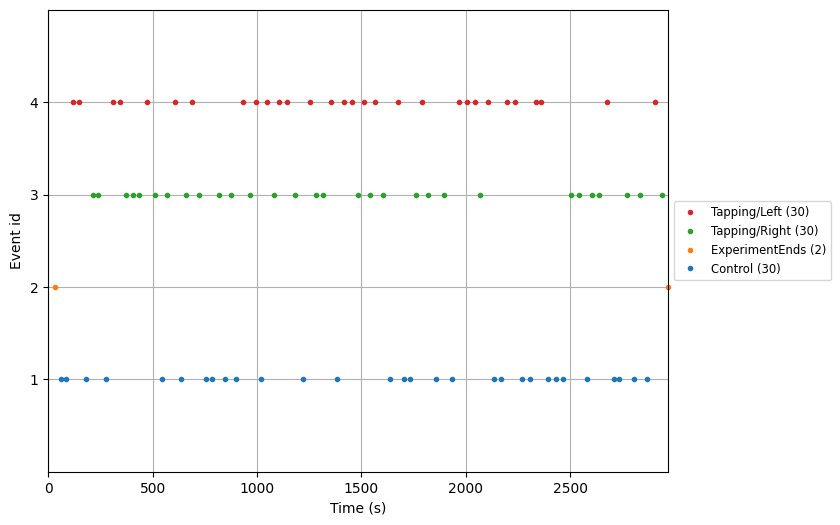

In [6]:
#Load the event annotations
events, event_dict=mne.events_from_annotations(raw_intensity,verbose=False)
#Assign each label to the event (based on recording setting)
event_dict={'Control':1,'Tapping/Left':4,'Tapping/Right':3,'ExperimentEnds':2}
#Display the sequence of events 
plt.rcParams["figure.figsize"]=(10,6)
mne.viz.plot_events(events,event_id=event_dict,sfreq=raw_intensity.info['sfreq']);

As you can see, there is a significant gap or interstimulus interval between each individual stimulus. We can thus conclude that an event-related design was employed in this experiment.

Now that we have gained an understanding of the experiment and recording processes, we can start the visualization of the raw data collected. To proceed, run the next cell.

Using matplotlib as 2D backend.


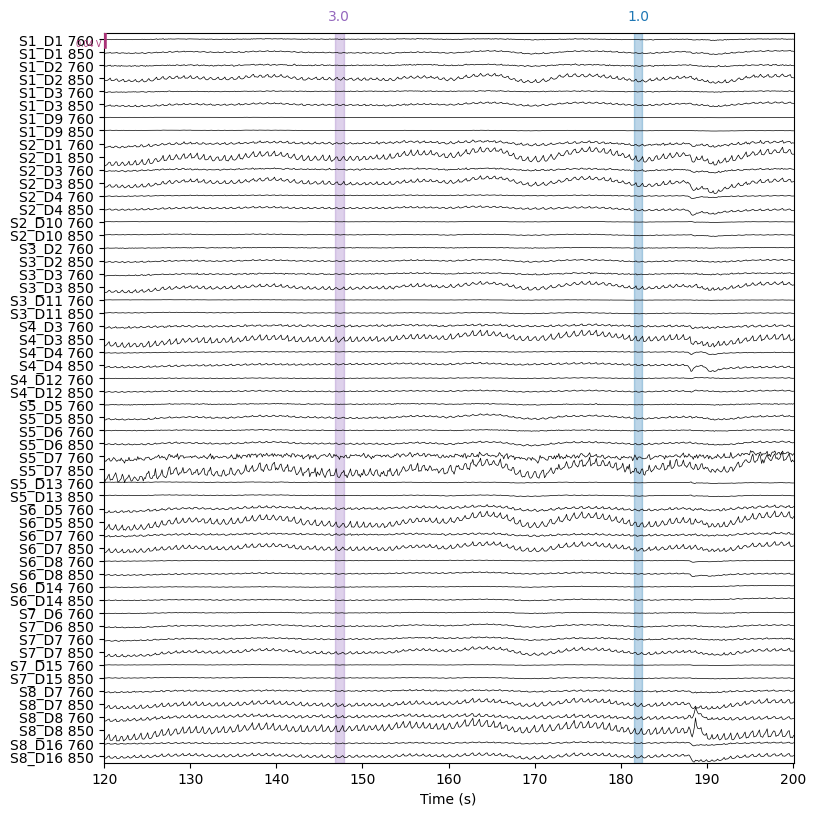

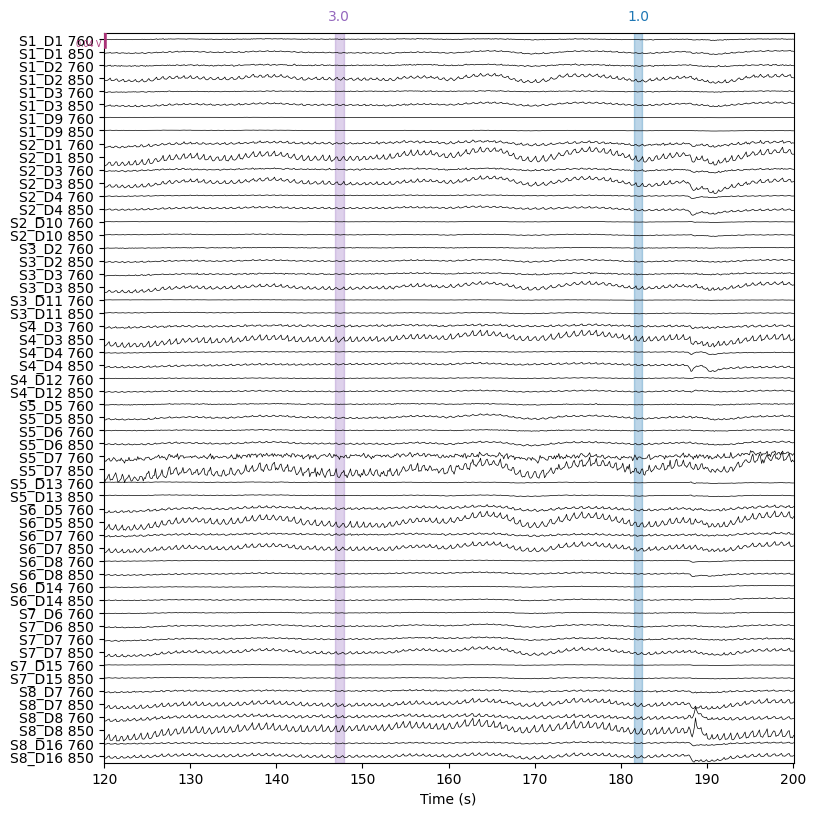

In [7]:
#Create a figure window
plt.rcParams["figure.figsize"]=(40,40)
#Plot time-series of raw light intensity data 
mne.viz.plot_raw(raw_intensity,start=120,duration=80,n_channels=56,show_scrollbars=False)

In this plot, we can observe the time-series of the data collected, represented as the change in light intensity resulting from light absorption at specific wavelengths. Oxygenated hemoglobin (HbO) absorbs light at "850"nm, while deoxygenated hemoglobin (HbR) absorbs light at "760"nm. Each channel comprises a pair consisting of a source (labeled as "S" in the plot) and a detector (labeled as "D" in the plot). 

Here, we are showing all the channels (y-axis) but, for clarity, we are only focusing on a specific timeframe, spanning from 120 to 200 seconds (x-axis). If you wish to customize the visualization parameters, please refer to the documentation of [mne.viz.plot_raw](https://mne.tools/stable/generated/mne.viz.plot_raw.html).

<span style="color:blue; text-decoration:underline;">Open question</span>

*Visually, are you able to localize a motion artifact?*

   <p style="color:green"> There are two types of motion artefacts we can visualize in this graph: a spike between 185-190s and a baseline shift in the S8_D8 850 channel. These two types of artefact can easily happen in motor tasks. </p>

### Preprocess the data

A typical preprocessing pipeline for fNIRS data includes the following key steps:

<hr>

*Step 1: Raw Intensity to Optical Density Conversion*

<hr> 

*Step 2: Motion Artifact Removal*

<p style='margin-top:1em;'>💡 This step is more effective when performed at the beginning of the pipeline to prevent the propagation of errors across wavelengths and minimizes cross talk between signals obtained at different wavelengths.

<hr> 

*Step 3: Optical Density to Concentration Conversion*

<hr>

*Step 4: Physiological Oscillation Filtering*

<p style='margin-top:1em;'>💡 This step is more effective when performed after the conversion step using the modified Beer-Lambert law, as physiological sources of error impact HbO and HbR in a manner consistent with the Beer-Lambert equation.
    
    
<hr>

#### Converting raw intensity data to optical density

The first step is to convert the changea in light intensity into changes in optical density using the modified Beer-Lambert law (Eq 1). 

\begin{equation}
OD_\lambda - OD_{R\lambda} = log\frac{I_o}{I} (1)
\end{equation}

With:
- $OD_\lambda$ the optical density of the medium for a given wavelength $\lambda$
- $OD_{R\lambda}$ the optical density of light scattering within human tissue
- $I_o$ the incident light intensity 
- $I$ the transmitted light intensity 

Run the next cell to convert raw intensity into optical density.

In [8]:
#Convert raw intensity into optical density data
raw_od=mne.preprocessing.nirs.optical_density(raw_intensity)

#### Correcting motion artefacts

In fNIRS data, two types of artifacts are commonly encountered: baseline shifts (indicating sensor displacement without returning to the initial position) and spike artifacts (characterized by sensor oscillations). As you correctly guessed earlier, the abrupt shift occurring around ~190 seconds in the time-series plot above corresponds to a spike artifact.

Here, we will employ a technique known as Temporal Derivative Distribution Repair (TDDR), which is designed to address baseline shifts and spikes. TDDR uses the temporal derivative of the signal to detect baseline shifts and spikes which are then used to correct the data. 

For a more comprehensive understanding of the TDDR method and its application, you can refer to the following paper:
- Frank A. Fishburn, Ruth S. Ludlum, Chandan J. Vaidya, and Andrei V. Medvedev. "Temporal Derivative Distribution Repair (TDDR): A Motion Correction Method for fNIRS." NeuroImage, 184:171–179, 2019. doi:10.1016/j.neuroimage.2018.09.025.

Run the cell below to apply the TDDR on the optical density data. 

In [9]:
#Apply TDDR on optical density data
raw_od_preproc=temporal_derivative_distribution_repair(raw_od)

Execute the following cell to visualize the optical density data after applying TDDR. 

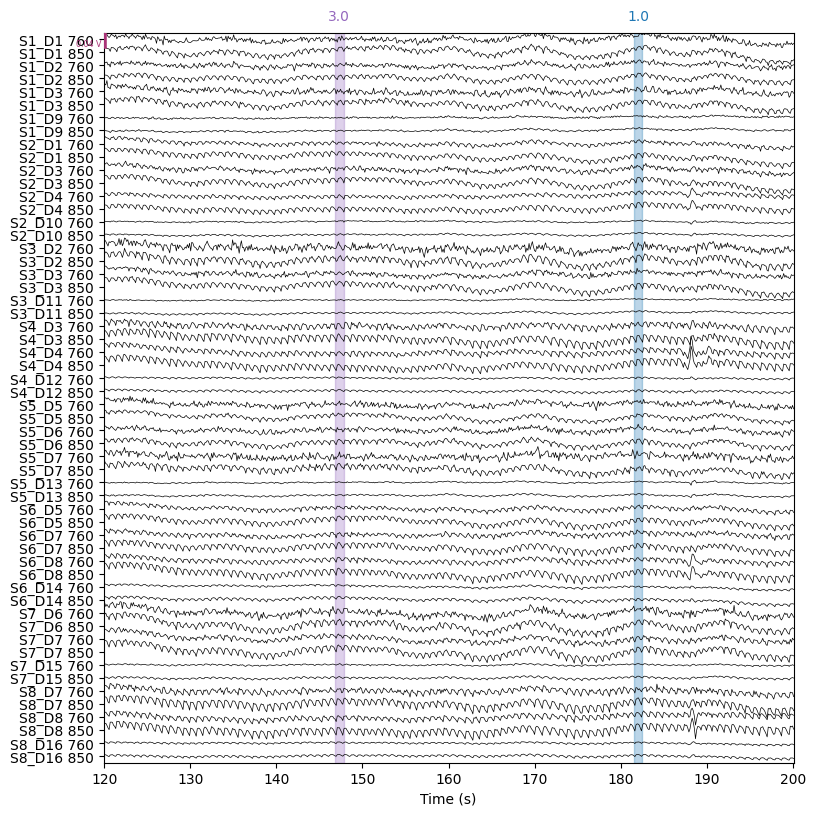

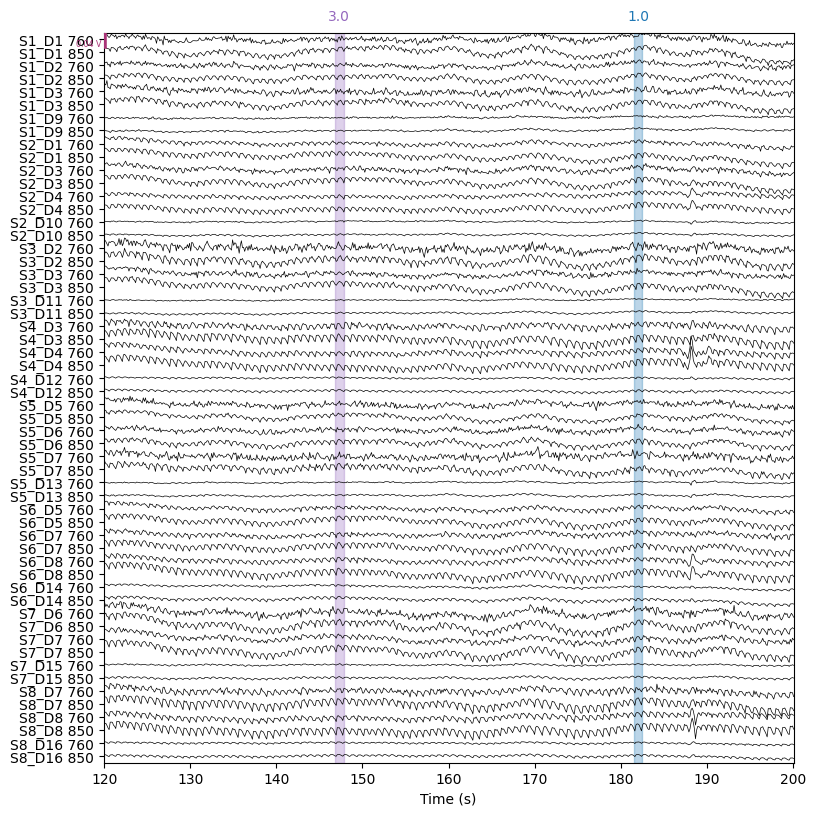

In [54]:
#Create a figure window
plt.rcParams["figure.figsize"]=(40,40)
#Plot time-series of optical density data following TDDR application
mne.viz.plot_raw(raw_od_preproc,show_scrollbars=False,start=120,n_channels=56,duration=80)

<span style="color:blue; text-decoration:underline;">Open question</span>

*From a visual standpoint, can we conclude that TDDR successfully eliminated the motion artifacts from your data?*

 <p style="color:green"> While the TDDR corrected the baseline shift seen in some of the channels (e.g., S8_D8 850) it did not remove the spikes from the signal. This is low sensitivity to motion-related spikes is actually one of the limits of the TDDR method. More robust methods that are however not proposed in mne-nirs library are the wavelet filtering or the spline interpolation.                                                                                                               For a comparison of motion artefact correction techniques, you can refer to the following paper:
    "Cooper, R. J., Selb, J., Gagnon, L., Phillip, D., Schytz, H. W., Iversen, H. K., ... & Boas, D. A. (2012). A systematic comparison of motion artifact correction techniques for functional near-infrared spectroscopy. Frontiers in neuroscience, 6, 147."</p>



#### Converting optical density to concentration 

The changes in optical density are then converted into changes of concentration using the modified beer lambert law (Eq 1): 

\begin{equation}
\Delta c = \frac{\Delta OD_\lambda }{\epsilon_\lambda lB} 
\end{equation}

Whith:
- $\Delta$ c the molar concentration change (in M)
- $\epsilon_\lambda$ the moral absorption coefficient (in $M^-1 cm^-1$) for a given wavelength $\lambda$
- l the the optical pathlength 
- B the pathlength correction factor

For more information on the equation, see the reference: Delpy DT, Cope M, Zee P van der, Arridge S, Wray S, Wyatt J. Estimation of optical pathlength through tissue from direct time of flight measurements. Phys Med Biol 1988; 33: 1433-1442.

Run the cell below to compute the concentration changes.

In [55]:
#Import required beer-lambert law related function
from mne.preprocessing.nirs import beer_lambert_law
#Convert optical density into concentration change (hemodnyamic data)
raw_haemo=beer_lambert_law(raw_od_preproc)

#### Filtering out physiological oscillations

Let's now filter out physiological oscillations.

To begin, we'll assess the extent of physiological oscillations within the data using power spectral density (PSD) analysis. Based on the sequence of events outlined previously, we note that stimuli for a same condition (e.g., tapping right) are presented at a rate of approximately once every 1/100 seconds. Consequently, we should anticipate a hemodynamic response to this specific stimulus occurring at this particular frequency. Any additional components identified in the PSD analysis can be attributed to other forms of oscillations, including physiological ones.

Run the following cell to initiate the signal decomposition process.

Effective window size : 32.768 (s)


C:\Users\RDZaharSe\Anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


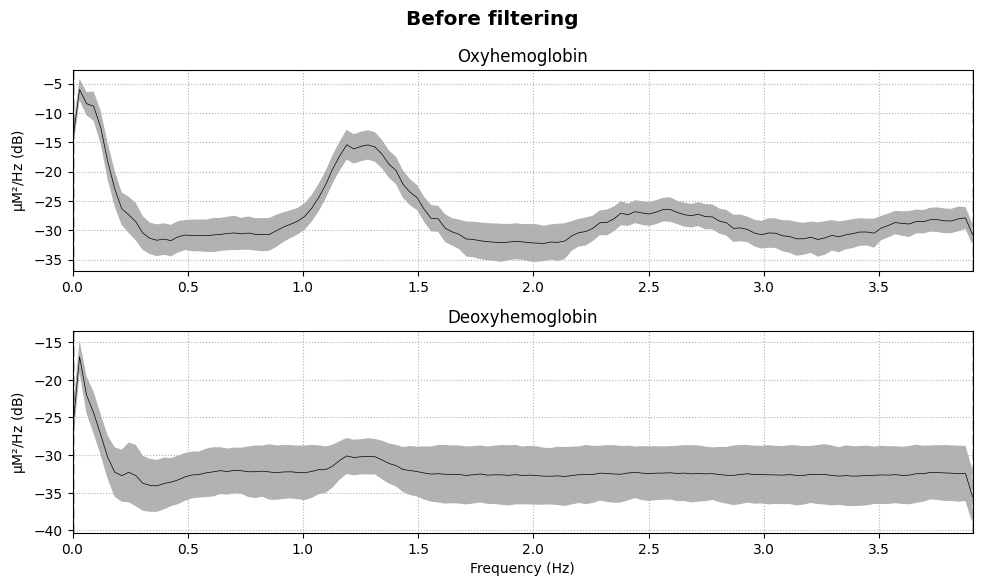

In [56]:
#Compute the PSD of non-filtered hemodynamic data 
fig = spectrum = raw_haemo.compute_psd().plot(average = True)
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
plt.show()

The PSD shows a very low peak which may correspond to the hemodynamic responses to task stimulations. On the other hand, the presence of a frequency peak at 1.25 Hz aligns with the heart rate. 

Based on the above information, apply a low-pass filter to only retain the hemodynamic responses. You may especially need to read the documentation on filters proposed by mne library (https://mne.tools/stable/generated/mne.filter.filter_data.html).

<p style="color:green"> MNE library provides two methods for filtering raw data: filter_data() function or the method filter. You can find all the functions, methods, and parameters associated with raw objects in the MNE documentation (https://mne.tools/stable/generated/mne.io.Raw.html). In the context of event-related designs, the goal is to extract hemodynamic responses to specific events. In our case, we aim to compare the hemodynamic responses to different events. 
Therefore, we have three distinct signals of interest: hemodynamic responses to 1) tapping left, 2) tapping right, and 3) control events.Maintaining the stimulation frequency in these signals is crucial. To determine this stimulation frequency, 
refer to the event sequence above. You'll notice there is around 1 stimulation per 100 seconds for each event. 
In the power spectrum above, you can identify a peak at approximately 0.01Hz, likely associated to this event-related hemodynamic response. You may also want to get rid of physiological oscillations: among the most important, there is the heart rate at ~1Hz and the breathing rate at ~0.3Hz. You can see the corresponding peaks in the PSD above. Based on this, the upper pass-band edge of your low pass filter can be set to 0.2Hz. You can use transbandwidth to make a smooth transition between the passband (0.2Hz) and the stopband (0.3Hz, frequency above which you will get your signal contaminated by physiological oscillations). Filters with narrow transition bandwidths are often preferred in applications where closely spaced frequency components need to be separated such as ours. However, be aware that you cannot narrow too much the transition bandwidth with low-order filters as the ones proposed by MNE library.</p>

In [42]:
#Let's try to filter our hemodynamic data using the function filter_data(). 
raw_haemofiltered_1 = mne.io.RawArray(mne.filter.filter_data(data=raw_haemo.get_data(), sfreq=raw_haemo.info['sfreq'], l_freq=0, h_freq=0.2, 
                                                           l_trans_bandwidth=0,h_trans_bandwidth=0.1), 
                                    info=mne.create_info(raw_haemo.ch_names,raw_haemo.info['sfreq'],'fnirs_cw_amplitude'))
#And now, let's try to filter the hemodynamic data using the filter method for raw objects 
raw_haemofiltered_2=raw_haemo.filter(0, 0.2, h_trans_bandwidth=0.1,
                             l_trans_bandwidth=0)

Setting up low-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 259 samples (33.152 sec)

Creating RawArray with float64 data, n_channels=56, n_times=23239
    Range : 0 ... 23238 =      0.000 ...  2974.464 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 259 samples (33.152 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.0s finished



<div class="warning" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b>💡 Pay attention! 💡</b></p>
<p style='text-indent: 10px;'> Whenever you apply a filter, you should check that you are not removing the signal of interest. For that, make sure the task stimulation frequency is not within the frequency range of your filter ! </p>
</span>
</div>

Run the next cell to plot the PSD of your filtered data.

<p style="color:green"> After using the filter_data() function, we need to select the time-series data for HbO and HbR separately (which got mixed by the function) and then apply the PSD analysis on each of them individually. To do so, run the next cell.</p>

Effective window size : 32.768 (s)


C:\Users\RDZaharSe\Anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


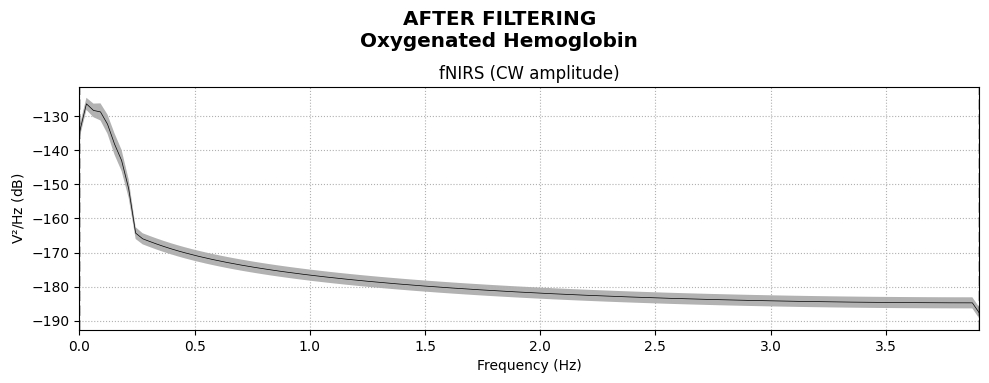

Effective window size : 32.768 (s)


C:\Users\RDZaharSe\Anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


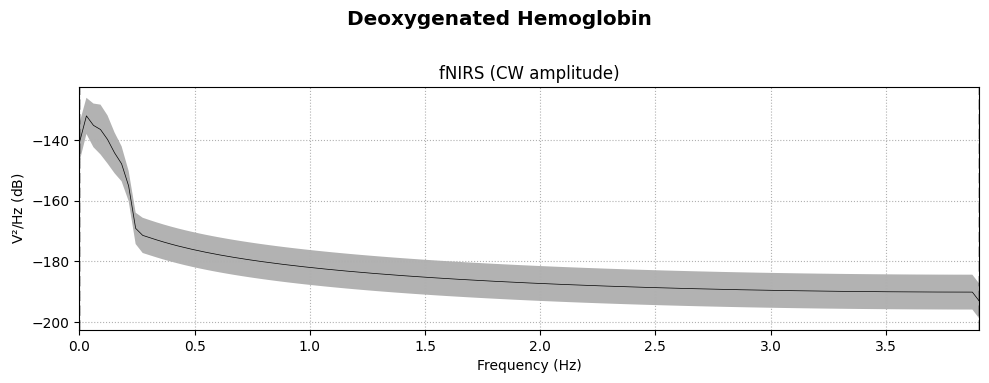

Effective window size : 32.768 (s)


C:\Users\RDZaharSe\Anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


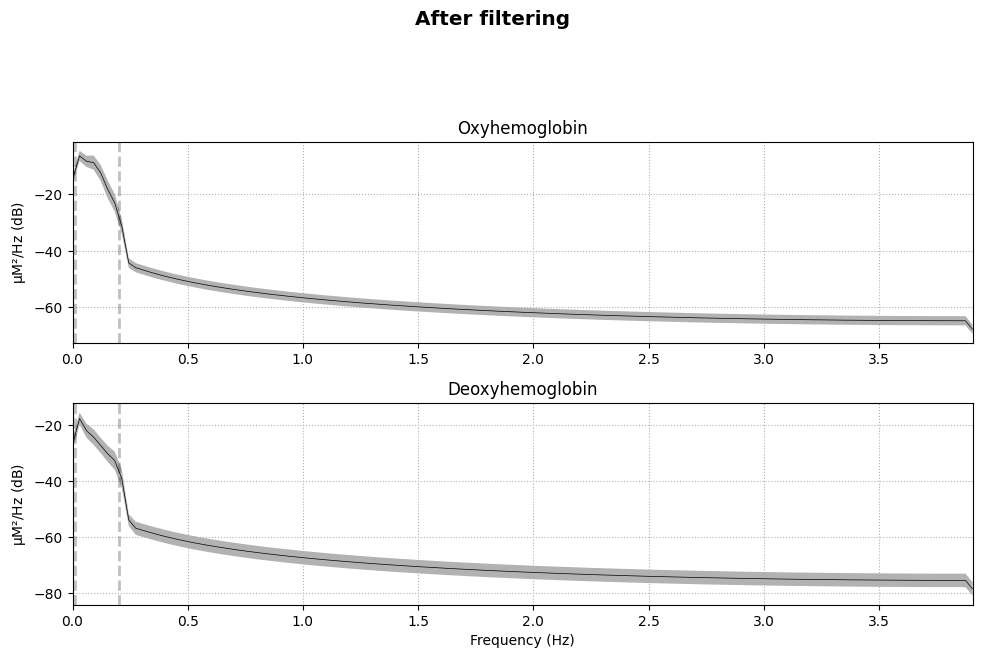

In [50]:
#Plot the spectrum of filtered hemodynamic data 

#Plot the spectrum for HbO time-series which are at even positions of ch_names 
fig = spectrum = raw_haemofiltered_1.copy().pick(raw_haemofiltered_1.ch_names[::2]).compute_psd().plot(average = True)
fig.suptitle('AFTER FILTERING\nOxygenated Hemoglobin', weight='bold', size='x-large',y=1.1)
fig.subplots_adjust(top=0.88)
plt.show()

#Plot the spectrum for HbR time-series which are at odd positions of ch_names 
fig = spectrum = raw_haemofiltered_1.copy().pick(raw_haemofiltered_1.ch_names[::1]).compute_psd().plot(average = True)
fig.suptitle('Deoxygenated Hemoglobin', weight='bold', size='x-large',y=1.1)
fig.subplots_adjust(top=0.88)
plt.show()


<p style="color:green"> The cell below is to run the PSD after using the filter method.</p>

In [ ]:
#Plot the spectrum of filtered hemodynamic data 
fig = spectrum = raw_haemofiltered_2.compute_psd().plot(average = True)
fig.suptitle('After filtering', weight='bold', size='x-large',y=1.1)
fig.subplots_adjust(top=0.88)
plt.show()

Run the next cell to visualize the filtered data.

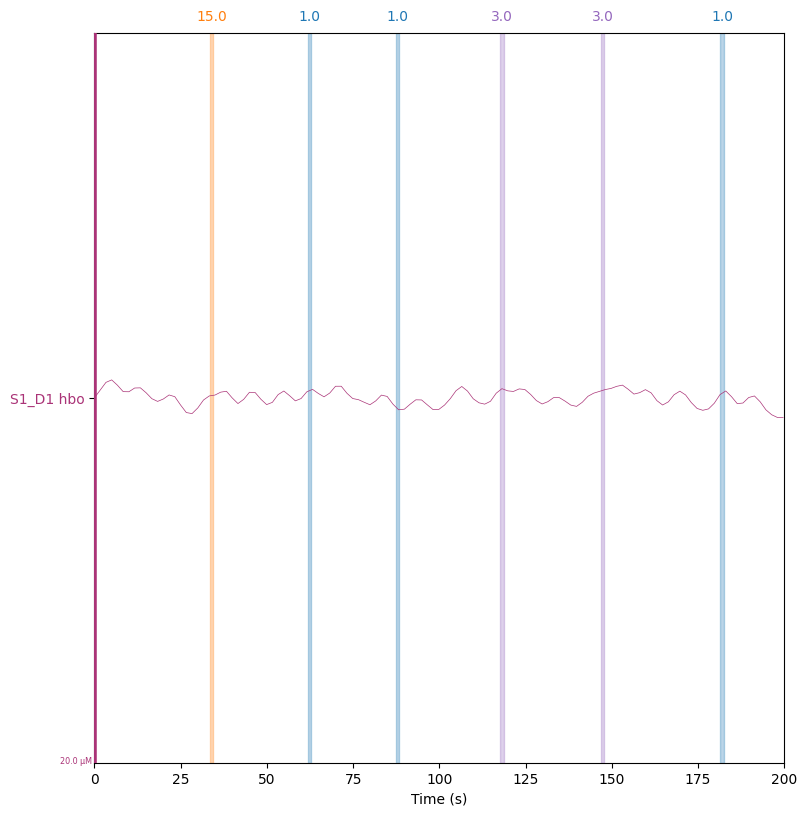

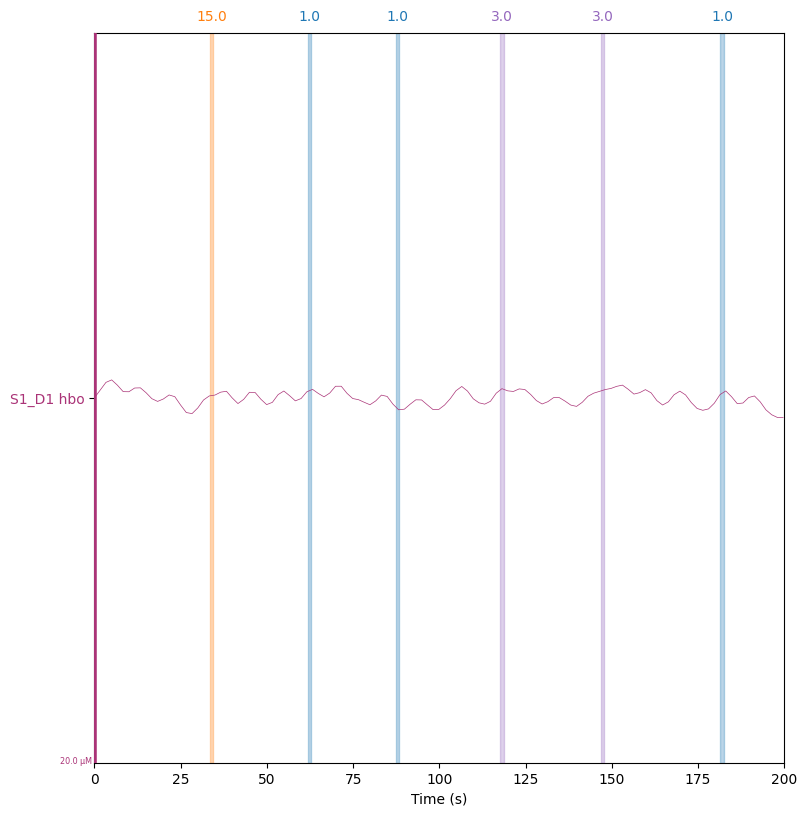

In [46]:
#Plot time-series of hemodynamic data obtained with one channel 
raw_haemofiltered_2.plot(start=0,duration=200,n_channels=1,show_scrollbars=False)

Congratulations ! You now have all the basics to understand and preprocess fNIRS data!  

<h1><font color='black'>Part 2: diffusion data and tractography generation </font></h1> 

The preprocessing in DTI involves similar steps to what you saw in fMRI. We will thus tackle specific different steps to not repeat ourselves too much:
<img src="imgs/DTI_preprocessing.png" />
<p  style="text-align: center;"><i>Image from <a href="https://www.researchgate.net/publication/311246309_Imaging_analysis_of_Parkinson's_disease_patients_using_SPECT_and_tractography">Son, Seong-Jin, Mansu Kim, and Hyunjin Park. "Imaging analysis of Parkinson’s disease patients using SPECT and tractography." Scientific reports 6.1 (2016): 1-11.</a></i></p>

In other words, we will have you look at an example to generate tractogram. Here, a tractogram will be generated using a deterministic algorithm EuDX.  
  
Diffusion tensor imaging (DTI) is one of the most popular MRI techniques to describe the orientation of white matter fibers in brain research. The process of fiber tracking is called tractography. It allows for a virtual dissection and three-dimensional representation of white matter tracts. 
While we could still use FSL for the task, we will have you use <a href="https://dipy.org/">DIPY</a>, a Python package for computational neuroanatomy mainly focusing on diffusion MRI analysis.  
<br>
To generate a tractogram, we need to track the fibers, which is called fiber tracking.
<br>
Local fiber tracking is used to model white matter fibers by creating streamlines from local directional information. In order to perform local fiber tracking, you will apply the following three steps:
<p >
    <ol>
        <li style="font-size: 15px;">Extract directions from diffusion data</li> 
        <li style="font-size: 15px;">Identify when the tracking must stop</li>  
        <li style="font-size: 15px;">Select a set of locations from which to begin tracking</li>
    </ol>
</p>
Combining them will help you obtain a tractography reconstruction!

Ready? Let's go!

## 0. An additional package
We require two additional packages for this lab to work! They are only for visualization.
To install them, you will need to use the following commands:
```
conda install -c conda-forge fury
conda install -c conda-forge ipyvtklink 
``` 

### 1. Load the data 

In [1]:
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

In [2]:
print('data.shape: ',data.shape)
print('affine.shape: ',affine.shape)
print('hardi_img.shape: ',hardi_img.shape)

print('labels.shape: ',labels.shape)
print('bvals.shape: ',bvals.shape)
print('bvecs.shape: ',bvecs.shape)

data.shape:  (81, 106, 76, 160)
affine.shape:  (4, 4)
hardi_img.shape:  (81, 106, 76, 160)
labels.shape:  (81, 106, 76)
bvals.shape:  (160,)
bvecs.shape:  (160, 3)


In [3]:
import os.path as op
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


print_dir_tree(op.split(hardi_fname)[0], max_depth=5)

|stanford_hardi/
|--- HARDI150.bval
|--- HARDI150.bvec
|--- HARDI150.nii.gz
|--- aparc-reduced.nii.gz
|--- label_info.txt


### 2. Get the directions from the diffusion data set

#### 1. Defining the white matter region.
Before all else, you will need to visualize the labels above. Run the following cell to load the labels on FSLeyes:

In [4]:
load(label_fname)
displayCtx.getOpts(overlayList[0]).cmap = 'brain_colours_spectrum'

Based on the values you read within, can you please fill in the cell below with the label corresponding to white matter?

In [5]:
white_matter_value = 1 # Fill with the value you read in FSLeyes for white matter!

Great, let's now visualize the result of the mask, shall we? For this, let's generate the mask we obtained from above, using our best pal fslmaths ! 

In [6]:
import os
output_name = 'extracted_wm'
cmd = 'fslmaths ' + label_fname + ' -thr ' + str(white_matter_value) + ' -uthr ' + str(white_matter_value) + ' -bin ' + output_name
os.system(cmd)
load(output_name)

Image(extracted_wm, /home/zhiwhuan/Downloads/Week3/Week3/extracted_wm.nii.gz)

That's nice, but we are missing something, aren't we? Look in the middle, there is a clear gap in purple. Why is that? If you have on top, you'll see it has a different label: 2. This is because this region is white matter, but it is also a sagittal slice of the **corpus callosum**. So we need to do something a bit different. Can you think of a way to modify the above fslmaths command to include both the white matter and the slice of corpus callosum ? :)

In [7]:
lower_threshold = 1 # Select the lower bound to include both white matter and corpus callosum slice
upper_threshold = 2 # Select the upper bound to include both white matter and corpus callosum slice
output_name = 'extracted_wm_complete'
cmd = 'fslmaths ' + label_fname + ' -thr ' + str(lower_threshold) + ' -uthr ' + str(upper_threshold) + ' -bin ' + output_name
os.system(cmd)
load(output_name)

Image(extracted_wm_complete, /home/zhiwhuan/Downloads/Week3/Week3/extracted_wm_complete.nii.gz)

Beautiful! So you can see that these labels can be a bit tricky if you're not careful. Based on your above experience above, we will construct a mask in python directly. Please fill in the cell below the two values for:
- The white matter regions
- The corpus callosum slice

In [8]:
corpus_callosum_slice_value = 2 # Fill with your value!
white_matter_value = 1 # Fill with your value !

total_white_matter = (labels == corpus_callosum_slice_value) | (labels == white_matter_value)

#### 2. Actually extracting fiber orientations: the orientation distribution function
Okay, now we have a mask to define our fibers. The next cell will be used to estimate the orientation distribution function at each voxel. Before going any further, let's ask why this is necessary. In your opinion, in a single *voxel* how many orientations can we have?
- [ ] Exactly one, since only one fiber is passing through the voxel
- [ ] One, as the orientation describes the voxel's orientation, not the fibers going through the voxel
- [ ] 26, since there are 26 neighbouring voxels with which a link is possible
- [X] As many orientations as there are fibers going through the voxel

<p style="color:green"> In theory, you can have all possible orientations because in a voxel, there are multiple fibers that can pass through. These orientations do not have to precisely align with the voxel grid since the fibers exist at a spatial resolution finer than that of voxels.</p>

The issue can be summarized as resolving **intravoxel** fiber orientations of MR images.
To summarize these, we use an orientation distribution function, coined ODF.

<div class=\"warning\" style='background-color:#C1ECFA; color: #112A46; border-left: solid darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span>
    <p style='margin-top:1em; text-align:center'><b>💡 Pay attention! 💡</b></p>
    <p style='text-indent: 10px;'>
        ODF really stands for orientation distribution function here, <b>not</b> ordinary differential function or anything else. Don't confuse the two!</p>
    </span>
</div>

We will not bore you with all mathematical details. What you need to know, however, is that this distribution function will rely on a special model, called the constant solid angle ODF model. The idea is the following: considering the distance from origin of the estimated distribution provides useful information. Here's what the solid angle looks like:
<img src="imgs/tractography/tileshop.jpeg"/>
<center>Left: pdf takes into account solid angle; Right: pdf does not take into account solid angle</center>
<i><center>Image taken from Aganj, Iman, et al. "Reconstruction of the orientation distribution function in single‐and multiple‐shell q‐ball imaging within constant solid angle." Magnetic resonance in medicine 64.2 (2010): 554-566.</center></i>


 

Let's now estimate the orientation distribution function of each voxel, using the CSA-ODF model. 

In [9]:
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

# Single fiber response function: the measured signal of a single fiber
# sume: regions where there are single coherent fiber populations
# auto_response_ssst: calculate FA for a ROI of radii equal to roi_radii in the center of the volume
# and return the response function estimated in that region for the voxels with FA higher than 0.7
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

# Instantiate the Constant Solid Angle model
csa_model = CsaOdfModel(gtab, sh_order=6)

Now that we have our model, the orientation of tract segments can be extracted, looking at the peaks in the model.

In [10]:
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=total_white_matter, npeaks=5)

Notice in the above cell the following line:
```python
csa_peaks = peaks_from_model(..., npeaks=5)
```

This means that really, we extract per voxel five peaks at most. This is an important assumption. Depending on your voxel size, you might want to pay attention to this number!

To confirm this, let's have a look at the extracted peak values: 

In [11]:
csa_peaks.peak_values.shape

(81, 106, 76, 5)

Knowing the MR dimensions, you can see that we indeed have five peaks per voxel. Great! Let's visualize it now!

## Checkpoint: install an additional library

<div class="alert alert-warning">
    <p>Please go on the terminal and install the library <b>fury</b> by running:</p>
        
        conda install -c conda-forge fury
</div>

<div class="alert alert-info">
    <i>Make sure you are on the usual environment!</i>  
</div>

In [13]:
from fury import actor, window, ui
from ipyvtklink.viewer import ViewInteractiveWidget

In [14]:
scene = window.Scene()
slice_actor = actor.peak_slicer(csa_peaks.peak_dirs,
                            csa_peaks.peak_values,
                            affine=affine,mask=total_white_matter,
                            colors=None)
scene.add(slice_actor)

showm = window.ShowManager(scene, size=(900,900), reset_camera=False)
showm.initialize()
ViewInteractiveWidget(scene.GetRenderWindow())

ViewInteractiveWidget(height=900, layout=Layout(height='auto', width='100%'), width=900)

So as you can see, the orientations do map out to the expected directions!

### 3. Set the stop criteria

Now, we need to setup our fiber tracking to stop it. What criterion should we use?
Well, we'll roughly use the idea that when we don't have enough evidence to know where a fiber could have gone, we stop tracking it.
In other words, if there are areas where the diffusion is totally unrestricted (goes in all directions), we have no clue as to where the fiber might continue. For this, we can threshold the tendency of our peaks to depend on a specific direction (anisotropy).<br>
More specifically, we will threshold the general fractional anisotropy of our data to decide when we should stop.

In [15]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

Let's visualize a slice! 

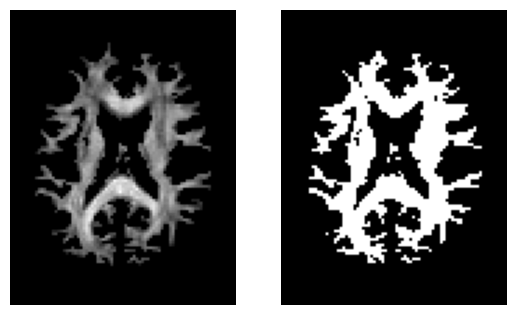

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

### 4. Specify where to begin the fibers tracking

There are different ways to place seeds, ie starting points from which the fiber tracking is started. This depends on the pathways you might like to model! For example, if you only wanted to model the corpus callosum it would not be so interesting to place seeds in other regions of the brain. <br>
So that you understand what the output of the cell below will be, we must first explain what you'll extract in the cell below.<br>
The orientation of an image is described by its affine transformation, if you remember well. Let's call this affine $A$.
A seed point at the center of voxel $[i,j,k]$ will be represented as $[x,y,z, 1]= A \cdot [i,j,k,1]$<br>
In other words, you will get **coordinates in voxel space**. Note that there is one important assumption: the voxels here should be isotropic (the size of a voxel should be same along all directions).

In our specific case, we will start from a sagittal slice of the **corpus callosum**, the one with label 2 to be specific.
Please, create the mask (based on the labels above) to extract **only the slice of corpus callosum with label 2 as a mask**. You can refer to what we did above to do so. 

In [17]:
from dipy.tracking import utils

seed_mask = labels == 2 # Your code here to extract only the place of interest! 
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

### 5. Bringing it all together and generating the streamlines
Let's see our ingredients:
- Seeds, generated above and starting from a slice of the corpus callosum
- A mask of regions where we should stop our fibers, based on anisotropy
- Peaks of ODF, at most five peaks per voxel

It remains now to combine all of these to bake so called streamlines (ie: fibers!). To do so, we will use the EuDX algorithm.

In [18]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines_t = Streamlines(streamlines_generator)

In [19]:
streamlines_t

ArraySequence([array([[ -4.5, -44.5,   7.5]]), array([[ -4.5, -44.5,   7.5]]), array([[ -4.5, -44.5,   7.5]]), ..., array([[-0.5, 32.5, 12.5]]), array([[ 0.5, 32.5, 12.5]]), array([[ 0.5, 32.5, 12.5]])])

Beautiful! Let's now visualize our streamlines!
Remember that they represent **only lines that start from the corpus callosum**! 

In [20]:
from dipy.viz import colormap

# Prepare the display objects.
color = colormap.line_colors(streamlines_t)

streamlines_actor = actor.line(streamlines_t,
                               colormap.line_colors(streamlines_t))

# Create the 3D display.
scene = window.Scene()
scene.add(streamlines_actor)

showm = window.ShowManager(scene, size=(900,900), reset_camera=False)
showm.initialize()
ViewInteractiveWidget(scene.GetRenderWindow())

# Save still images for this static example. Or for interactivity use
#window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
#if interactive:
#    window.show(scene)

ViewInteractiveWidget(height=900, layout=Layout(height='auto', width='100%'), width=900)

### 6. Store the streamlines into a trackvis file

What if we wanted to save the result as a file? Well, you can! For this, we need to save it to a special format, the TrackVis (.trk) format.

Remember: our goal was to generate the streamlines. It is these streamlines that we therefore want to save! :) 
Let's do it! 

In [21]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram, save_trk

# This is for the cc slice tractogram
sft = StatefulTractogram(streamlines_t, hardi_img, Space.RASMM)
save_trk(sft, "tractogram_EuDX.trk", streamlines_t)


If you want to visualize it all, you can install <a href="http://trackvis.org/download/">TrackVis</a> and open the file from within! (TrackVis is free, no worries). It will be interactive and in 3D! Pretty cool huh?<br> 

### Conclusions

Let's sum up what we've seen. For a successfull tractography generation, we need the following: 
<table>
    <tr>
        <th>Ingredient</th>
        <th>Role</th>
        <th>How is it created?</th>
    </tr>
    <tr>
        <td>Seeds</td>
        <td>Define starting point of tract propagation.</td>
        <td>Can be done randomly or according to some mask of interest</td>
    </tr>
    <tr>
        <td>Diffusion directions</td>
        <td>Define the local diffusion in a voxel, for all voxels of interest</td>
        <td>Can be done with CSA-ODF or other methods such as e.g structure tensor</td>
    </tr>
    <tr>
        <td>Stopping criteria</td>
        <td>Defines where the tract continues or stops.</td>
        <td>Can be done based on anatomy, information of diffusion direction, combination of both...</td>
    </tr>
    <tr>
        <td>A tracking algorithm</td>
        <td>Combines all ingredients above to generate streamlines</td>
        <td>Line propagation techniques to grow from seed region, or probabilistic with a pdf of fiber orientations.</td>
    </tr>
</table> 

<img src="imgs/tractography/4qamin.jpg"/>

Each of the ingredients can be changed for a different flavour. You can explore <a href="https://dipy.org/tutorials/">DIPY's tutorials</a> to get an idea of the changes you can operate. Feel free to play around!

# Additional: Connectivity analysis based on tractography 

By using the generated streamlines, we could analize the brain connectivity, for example, which streamlines pass through or not pass through some regions of the brain, how many streamlines are connecting two ROI, etc. To do this, it would be better if we could create a tractography with seeds spaning the entire white matter. Due to RAM concern, we will not do it here. But please feel free to explore it if you are interested! You will find some useful tutorials here:
   https://dipy.org/documentation/1.7.0/examples_built/#streamlines-analysis-and-connectivity

This ends this short tractography tutorial! Again, do not hesitate to explore more on DIPY's website if you're interested :)
We strongly encourage you to use TrackVis for visualization of tractograms as it's really made for it and is much more intuitive to use for this purpose than FSLeyes.

   


<div class="alert alert-success">
<p><b>Congratulations for having finished this part of the laboratory! </b></p>
</div>